In [1]:
import pandas as pd
import numpy as np
from data import get_historical_data

from sklearn.cluster import AgglomerativeClustering
import mplfinance as mpf


In [6]:
stock_df = get_historical_data('2337.TW')

In [7]:
stock_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2000-01-04,71.916896,73.076859,67.857075,68.437050,71505593.0,0.0,0.0
2000-01-05,66.117162,70.756958,66.117162,69.597008,57598803.0,0.0,0.0
2000-01-06,69.597019,70.756970,68.437069,69.017044,43747437.0,0.0,0.0
2000-01-07,67.277100,70.176975,65.537179,68.437050,37015484.0,0.0,0.0
2000-01-10,70.176982,73.076866,69.597007,73.076866,50225134.0,0.0,0.0


## 利用層次聚類找支撐

In [58]:
def generate_SR_line(df,rolling=20, duration=100, n=4, figsize = (20, 10)):
    

    df = df.iloc[-(duration+rolling):] # for the rolling obs waves 
    date = df.index
    
    df.reset_index(inplace=True) 

    mx = df.High.rolling(rolling).max().rename('waves')
    mn = df.Low.rolling(rolling).min().rename('waves')

    mx_waves = pd.concat([mx,pd.Series(np.zeros(len(mx))+1)],axis = 1)
    mn_waves = pd.concat([mn,pd.Series(np.zeros(len(mn))+-1)],axis = 1)    

    mx_waves.drop_duplicates('waves',inplace = True)
    mn_waves.drop_duplicates('waves',inplace = True)

    W = mx_waves.append(mn_waves).sort_index().dropna()


    X = np.concatenate((W.waves.values.reshape(-1,1),
                        (np.zeros(len(W))+1).reshape(-1,1)), axis = 1 )

    cluster = AgglomerativeClustering(n_clusters=n,
              affinity='euclidean', linkage='ward')
    cluster.fit_predict(X)
    W['clusters'] = cluster.labels_

    W2 = W.loc[W.groupby('clusters')['waves'].idxmax()]
    df.index = date 

    mc = mpf.make_marketcolors(up='r',
                            down='g',
                            edge='',
                            wick='inherit',
                            volume='inherit')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
    mpf.plot(df, type='candle', style=s, volume=True,
        hlines=dict(hlines=W2.waves.to_list(), linestyle='dashed', alpha=0.7),figsize=figsize)


    W2.waves.drop_duplicates(keep='first', inplace=True)
    
    return W2.reset_index().waves

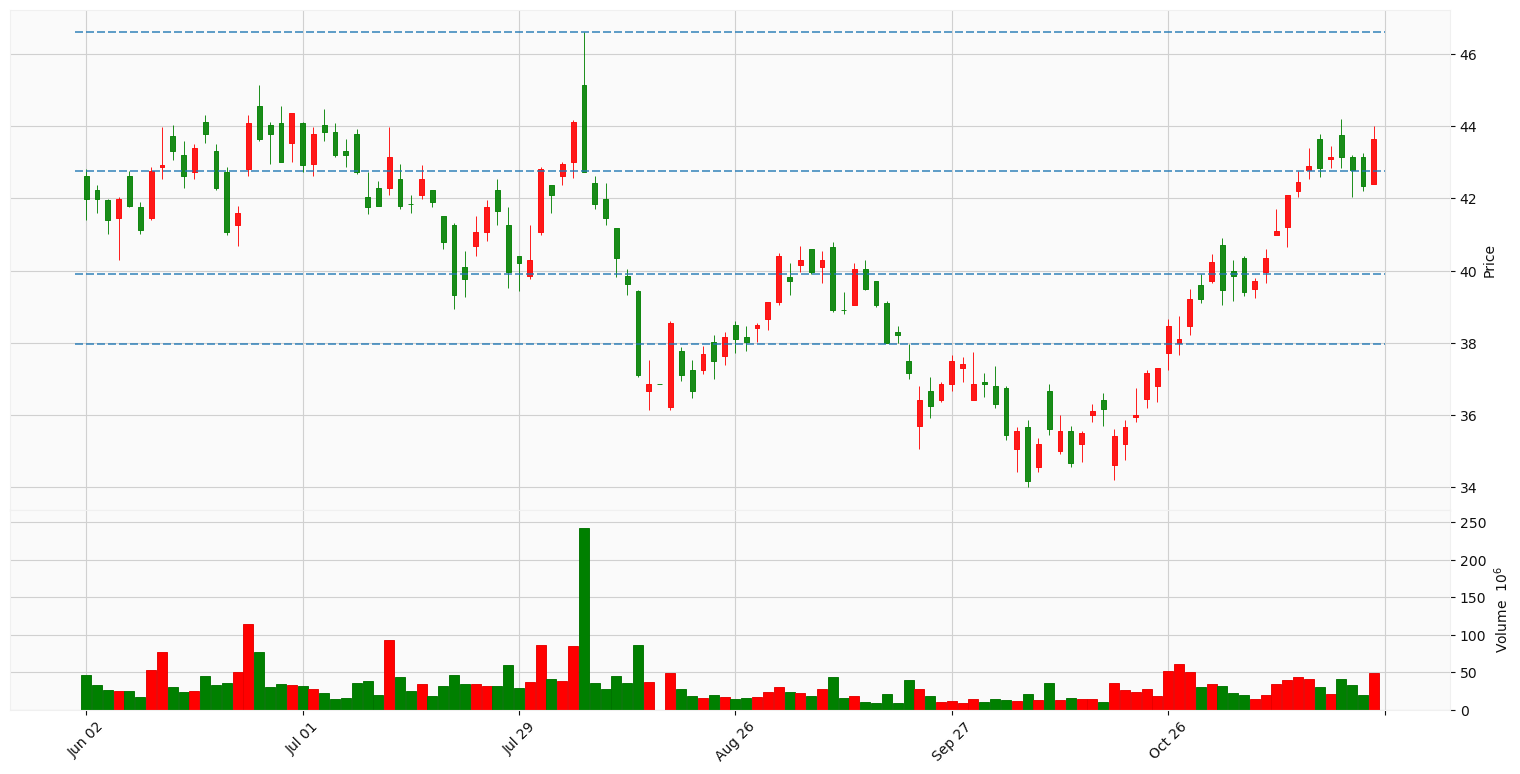

In [59]:
W2 = generate_SR_line(stock_df.copy(), duration=100)